## Exemplo de classificador com leitura do CSV. 

Etapas:

- Leitura CSV.
- Tratamento de imagens com lib PIL. 
- Leitura imagem. 
- Aplicacao Filtro para remocao background


Input do modelo : (Imagem, sexo, idade, etnia)

In [ ]:
!pip install -r requirements.txt

In [28]:
import pandas as pd
from PIL import Image, ImageChops
import numpy as np
import torch
from lib.ImageFIlter import treat_image_PIL
from sklearn.model_selection import KFold
from torch.utils.data import  DataLoader, TensorDataset, Dataset


In [20]:
ds_file = pd.read_csv('dataset/exemplo_csv_2.csv')


## Geracao Tensor com imagens filtradas

In [25]:
## Loop
img_dataset = np.ones((ds_file.shape[0],256,256),dtype=np.uint8)

j=0
for i in ds_file['path']:
    img_dataset[j]=treat_image_PIL('dataset/path/'+i,1)
    j+=1
tensor_imagem = torch.tensor(img_dataset)


## Geracao Tensor Age, sex, Etinia

Encoding: 

- Sexo: M=0 F=1

- Idade: Normalizar? Sim, dividir por 100 igual o artigo do Marco e Felipe fizeram. 

- Etnia: Encoding simples de categorias. Utilizaremos o Label Encoding para isso 

In [11]:
ds_id_sex_et= ds_file[['IDADE', 'SEXO', 'ETNIA']]
ds_id_sex_et['SEXO'] = ds_file['SEXO'].map({ 'M':0, 'F':1})
ds_id_sex_et['IDADE'] = ds_file['IDADE']/100

/var/folders/30/pgp77_r92w5_rn1ghx4kn51h0000gn/T/ipykernel_56713/1074131203.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_id_sex_et['SEXO'] = ds_file['SEXO'].map({ 'M':0, 'F':1})
/var/folders/30/pgp77_r92w5_rn1ghx4kn51h0000gn/T/ipykernel_56713/1074131203.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_id_sex_et['IDADE'] = ds_file['IDADE']/100


In [23]:
## Encoding variavel ETNIA -> Usando label Encoding
from sklearn.preprocessing import LabelEncoder

# Create a sample dataframe with categorical data

#print(f"Before Encoding the Data:\n\n{ds_id_sex_et['ETNIA']}\n")

# Create a LabelEncoder object
le = LabelEncoder()

# Fit and transform the categorical data
ds_id_sex_et['ETNIA'] = le.fit_transform(ds_id_sex_et['ETNIA'])
ds_id_sex_et

,IDADE,SEXO,ETNIA
0,0.85,0,1
1,0.32,1,1
2,0.60,1,1
3,0.57,1,4
4,0.57,1,1
...,...,...,...
211,0.35,1,3
212,0.72,0,2
213,0.71,1,2
214,0.49,0,2


## Geracao de rótulos para classificação

Colunas utilizadas para classificacao (Labels)

labels = [ 'FA', 'TA/Flutter',
       'TPSV/TS', 'TV/FV', 'BAV 2º/3º/Avanc./BS', 'Supra ST',
       'Corrente de Lesao', 'Extrassistole', 'BRD', 'BRE', 'MP', 'Normal',
       'Outros', 'Exclusão']

In [22]:
##
ds_file.columns
labels = [ 'FA', 'TA/Flutter',
       'TPSV/TS', 'TV/FV', 'BAV 2º/3º/Avanc./BS', 'Supra ST',
       'Corrente de Lesao', 'Extrassistole', 'BRD', 'BRE', 'MP', 'Normal',
    'Outros']
ds_labels = ds_file[labels]
ds_labels=ds_labels.astype(int)#,'False':0})
tensor_label = torch.tensor(np.array(ds_labels))
tensor_label

tensor([[0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 1, 1,  ..., 0, 1, 0],
        [0, 1, 0,  ..., 0, 0, 1],
        [1, 0, 0,  ..., 1, 0, 0]])

In [24]:
ds_file['Normal']

0      False
1      False
2      False
3      False
4      False
       ...  
211    False
212     True
213     True
214    False
215    False
Name: Normal, Length: 216, dtype: bool

### Resumo:

model(tensor_imagem,ds_id_sex_et)

labels : tensor_label

## Criacao Subset 



In [ ]:
class Subset(Dataset):
    r"""
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
    """
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

    def __len__(self):
        return len(self.indices)

    @property
    def classes(self):
        return self.data.classes

## K-fold = 10


In [29]:
kf = KFold(n_splits=5)
kf.get_n_splits(tensor_imagem)
print(kf)
#for i in enumerate(kf.split(tensor_imagem)):
#    print(i)

KFold(n_splits=5, random_state=None, shuffle=False)


## Create a model to concat layers

O modelo utilizado será o mesmo do artigo: Artificial Intelligence-Driven Screening System for Rapid Image-Based Classification of 12-Lead ECG Exams: A Promising Solution for Emergency Room Prioritization 

Desenvolvido conforme a figura abaixo: 

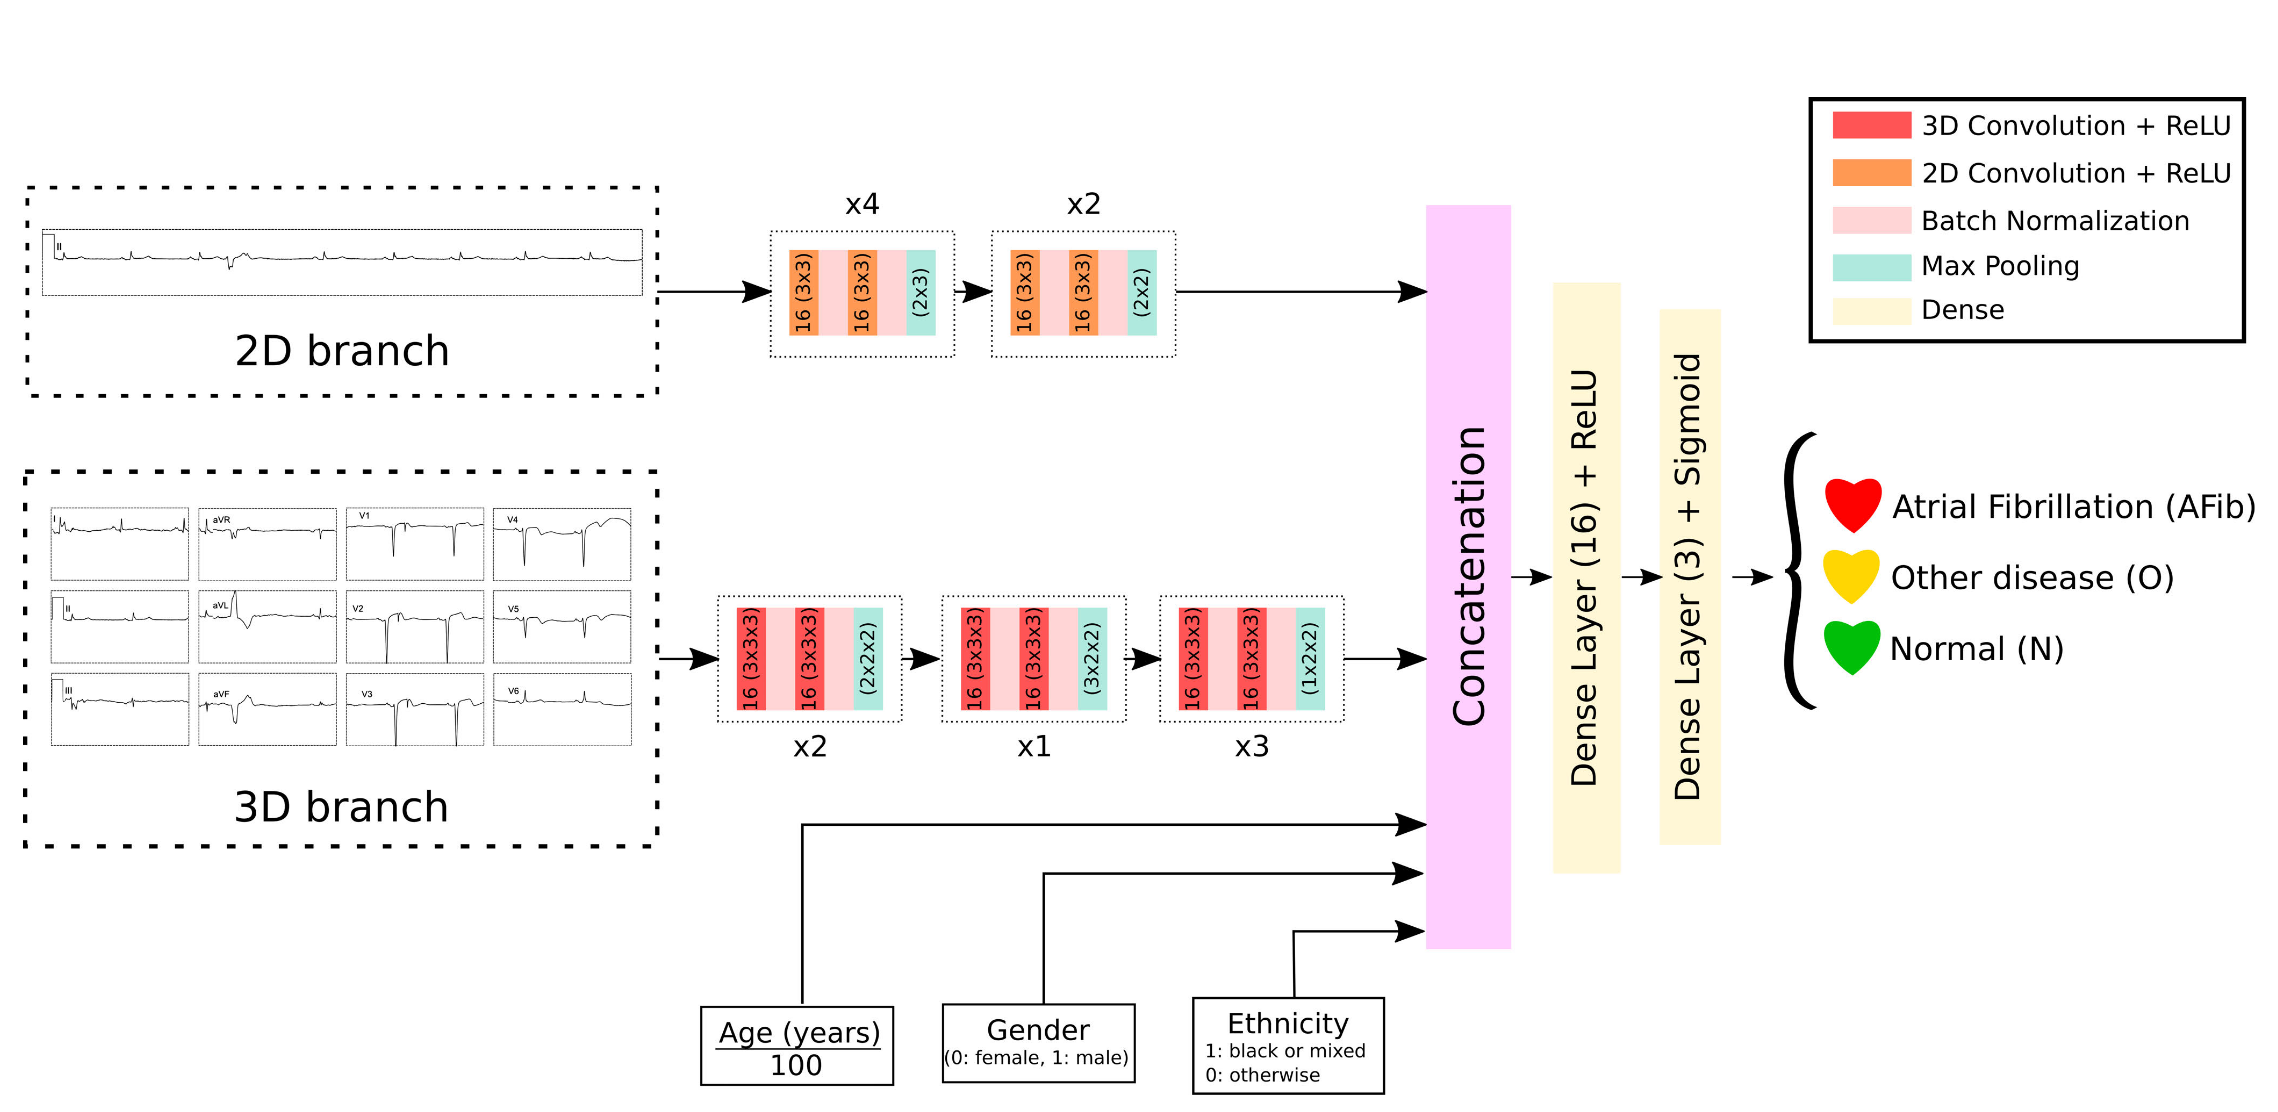

In [ ]:
class ECGClassifierAIntelligence(nn.Module):    
    def __init__(self, num_classes=53):
        super(ECGClassifierAIntelligence, self).__init__()
        # Where we define all the parts of the model
        #self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        enet_out_size = int(32*(250*250)/25)      # 32 canais de imagens 250x250 passando por um maxpooling de 5x5 (32x250x250)/(5x5)

        #self.base_model = timm.create_model('vit_mediumd_patch16_reg4_gap_256.sbb2_e200_in12k_ft_in1k',num_classes=32)
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=16,kernel_size=(3,3)), ## 3, 256,256 -> 32, 254,254
        nn.ReLU(),
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3)), ## 32, 254,254 -> 64, 252,252 
        nn.ReLU(), nn.MaxPool2d((2,3)))
        
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(3,3)), ## 3, 256,256 -> 32, 254,254
        nn.ReLU(),
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3)), ## 32, 254,254 -> 64, 252,252 
        nn.ReLU(), nn.MaxPool2d((3,3)))



        self.layer2= 
        self.model = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(3,3)), ## 3, 256,256 -> 32, 254,254
        nn.ReLU(),
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3)), ## 32, 254,254 -> 64, 252,252 
        nn.ReLU(),
        nn.Conv2d(in_channels=64,out_channels=32,kernel_size=(3,3)), ## 32, 250,250 ,
        nn.MaxPool2d(5),
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes), nn.Sigmoid())
    
         # saida como linear 
    
    def forward(self, img_tensor, sex,etnia,age):
        # Connect these parts and return the output
        #x = self.features(x)
        output = self.model(img_tensor) ## saída linear 
        concatenated = torch.cat(output,sex,etnia,age)
        return output

In [ ]:
class ECGClassifierResnet(nn.Module):    
    def __init__(self, num_classes=53):
        super(ECGClassifierResnet, self).__init__()
        # Where we define all the parts of the model
        #self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        enet_out_size = int(32*(250*250)/25)      # 32 canais de imagens 250x250 passando por um maxpooling de 5x5 (32x250x250)/(5x5)

        #self.base_model = timm.create_model('vit_mediumd_patch16_reg4_gap_256.sbb2_e200_in12k_ft_in1k',num_classes=32)
        self.model = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(3,3)), ## 3, 256,256 -> 32, 254,254
        nn.ReLU(),
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3)), ## 32, 254,254 -> 64, 252,252 
        nn.ReLU(),
        nn.Conv2d(in_channels=64,out_channels=32,kernel_size=(3,3)), ## 32, 250,250 ,
        nn.MaxPool2d(5),
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes), nn.Sigmoid())
    
         # saida como linear 
    
    def forward(self, img_tensor, sex,etnia,age):
        # Connect these parts and return the output
        #x = self.features(x)
        output = self.model(img_tensor) ## saída linear 
        concatenated = torch.cat(output,sex,etnia,age)
        return output